## Classification based on expert labeling and Decision Tree model
Using phillipines data based FSLSM and ILS Computed by the experts.
Paper Author, Renato et al (2017): [CLASSIFICATION OF LEARNING STYLES IN VIRTUAL LEARNING ENVIRONMENT USING J48 DECISION TREE](https://www.researchgate.net/publication/336313535_CLASSIFICATION_OF_LEARNING_STYLES_IN_VIRTUAL_LEARNING_ENVIRONMENT_USING_J48_DECISION_TREE)

### 1. Loading Libraries

In [1]:
import numpy as np
import math
import random
from scipy.stats import norm
from sklearn.preprocessing import normalize as nz
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import metrics #confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import time
import pandas as pd
#from  .model.MDBN import MDBN

In [2]:

#seed for reproducibility
SEED = 3425
random.seed(SEED)
rng = np.random.seed(SEED)

### 2. Loading learning traces

In [3]:
#Extract traces
ar = pd.read_excel("/Users/maxwell/Documents/phili2017/ls_processing.xlsx")
ar.head()


,forum_post,forum_view,self_assesment,text_materials,PROCESSING
0,1,2,8,27,ACTIVE
1,11,6,3,0,REFLECTIVE
2,21,10,7,29,ACTIVE
3,9,2,8,1,ACTIVE
4,4,3,8,17,ACTIVE


In [4]:
features_ar = list(ar.columns.values)
print(features_ar)
features_ar.remove('text_materials')
features_ar.remove('PROCESSING')
ar["label"] = ar["PROCESSING"].apply(lambda x : 1 if x=="ACTIVE" else 0)
features_ar.append("label")
ar = ar[features_ar]
print(ar.values[:,0:-1])


['forum_post', 'forum_view', 'self_assesment', 'text_materials', 'PROCESSING']
[[ 1  2  8]
 [11  6  3]
 [21 10  7]
 ...
 [ 4  8  3]
 [ 7 12  3]
 [ 1 18  1]]


In [5]:
si = pd.read_excel("/Users/maxwell/Documents/phili2017/ls_perception.xlsx")

In [6]:
features_si = list(si.columns.values)
print(features_ar)
features_si.remove('PERCEPTION')
si["label"] = si["PERCEPTION"].apply(lambda x : 1 if x=="SENSING" else 0)
features_si.append("label")
si = si[features_si]
print(si.values[:,0:-1])
si

['forum_post', 'forum_view', 'self_assesment', 'label']
[[ 7 12  4  7]
 [ 7  6  6  9]
 [ 8  7  2  6]
 ...
 [ 2  4  7 14]
 [ 2  5  5 13]
 [10 12 12  8]]


,concrete_materials,abstract_materials,examples,exercises,label
0,7,12,4,7,0
1,7,6,6,9,1
2,8,7,2,6,0
3,18,11,10,9,1
4,18,7,5,4,1
...,...,...,...,...,...
502,3,10,6,13,0
503,14,10,7,2,1
504,2,4,7,14,0
505,2,5,5,13,0


In [7]:
vv = pd.read_excel("/Users/maxwell/Documents/phili2017/ls_input.xlsx")
vv.head()

,visual_materials,text_materials,video_materials,forum_posts,INPUT
0,11,27,9,1,VISUAL
1,7,0,11,11,VISUAL
2,16,29,9,21,VISUAL
3,20,1,8,9,VISUAL
4,30,17,9,4,VISUAL


In [8]:
features_vv = list(vv.columns.values)
print(features_vv)
features_vv.remove('INPUT')
features_vv.remove('forum_posts')
features_vv.remove('text_materials')
vv["label"] = vv["INPUT"].apply(lambda x : 1 if x=="VISUAL" else 0)
features_vv.append("label")
vv = vv[features_vv]
print(vv.values[:,0:-1])
vv.head()

['visual_materials', 'text_materials', 'video_materials', 'forum_posts', 'INPUT']
[[11  9]
 [ 7 11]
 [16  9]
 ...
 [18 13]
 [18  7]
 [13  7]]


,visual_materials,video_materials,label
0,11,9,1
1,7,11,1
2,16,9,1
3,20,8,1
4,30,9,1


In [9]:
sg = pd.read_excel("/Users/maxwell/Documents/phili2017/ls_understanding.xlsx")

In [10]:
features_sg = list(sg.columns.values)
print(features_sg)
features_sg.remove('UNDERSTANDING')
sg["label"] = sg["UNDERSTANDING"].apply(lambda x : 1 if x=="SEQUENTIAL" else 0)
features_sg.append("label")
sg = sg[features_sg]
print(sg.values[:,0:-1])


['course_overviews', 'nav_pattern_distance', 'UNDERSTANDING']
[[3.         5.29150262]
 [2.         6.4807407 ]
 [3.         6.08276253]
 ...
 [4.         5.19615242]
 [6.         4.69041576]
 [4.         6.55743852]]


In [11]:
data = {}
data[0] = ar.values[:,:-1],ar.values[:,-1] #np.load('./data/phili2017/features/origin/ar.npy'),np.load('./data/phili2017/labels/labels_ar.npy')
data[1] = si.values[:,:-1],si.values[:,-1] #np.load('./data/phili2017/features/origin/si.npy'),np.load('./data/phili2017/labels/labels_si.npy')
data[2] = vv.values[:,:-1],vv.values[:,-1]#np.load('./data/phili2017/features/origin/vv.npy'),np.load('./data/phili2017/labels/labels_vv.npy')
data[3] = sg.values[:,:-1],sg.values[:,-1]#np.load('./data/phili2017/features/origin/sg.npy'),np.load('./data/phili2017/labels/labels_sg.npy')


In [12]:
mat_ar = data[0][0]
mat_si = data[1][0]
mat_vv = data[2][0]
mat_sg = data[3][0]


### Define the context of the data

In [13]:
LS = ['Processing', 'Perception', 'Input', 'Understanding']
Classes = {} #Style d'apprentissage
Classes[0] = ["Active","Reflective"]
Classes[1] = ["Sensitive","Intuitive"]
Classes[2] = ["Visual","Verbal"] 
Classes[3] = ["Sequential","Global"] 
FSLSM = ["A/R","S/I","V/V","S/G"]

In [14]:
features = {}
features[0] = ["forum_post","forum_view","self_assesment","text_materials "]
features[1] = ["concrete_materials","abstract_materials","examples","exercises"	]
features[2] = ["visual_materials","text_materials","video_materials","forum_posts"]
features[3] = ["course_overviews","nav_pattern_distance"]

In [15]:
#Number of zero of the matrix
print("Data provided where Already preprocessed by the author")
print ("Active Reflective remove:  {} ".format(features[0][-1]))
print ("Visual Verbal remove:  {} {} ".format(features[2][1],features[2][3]))
mat_vv[0:2,:]

Data provided where Already preprocessed by the author
Active Reflective remove:  text_materials  
Visual Verbal remove:  text_materials forum_posts 


array([[11,  9],
       [ 7, 11]])

In [16]:
print ("Active Reflective shape:   ",mat_ar.shape)
print ("Sensitive Intuitive shape: ",mat_si.shape)
print ("Visual Verbal shape:       ",mat_vv.shape)
print ("Sequential Global shape:   ",mat_sg.shape)

Active Reflective shape:    (507, 3)
Sensitive Intuitive shape:  (507, 4)
Visual Verbal shape:        (507, 2)
Sequential Global shape:    (507, 2)


### 4. Normalize the data

In [17]:
def normalize(x):
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    return (x-mean)/std

In [18]:
#len(mat_ar_filt.mean(axis=0))
norm_mat_ar_filt = normalize(mat_ar)
norm_mat_si_filt = normalize(mat_si)
norm_mat_vv_filt = normalize(mat_vv)
norm_mat_sg_filt = normalize(mat_sg)

### 5. Clustering of the data for user preferences

In [19]:
from sklearn.cluster import KMeans

### We define k = 4 regarding the feature hint level of learning styles prefernces (Bernard, 2017 and Graf 2009). 3=good ; 2=moderate ; 1=low; 0=absence

In [20]:
'''
 Build the Hint matrix.
 Define a function which form a cluster of 4 groups for each    pattern(featues) in a learning style dimension.
'''
def build_clusters_preferences(X,k=4):
    (m,n) = X.shape
    Hint = np.zeros((m,n))
    km = KMeans(k,init='k-means++',max_iter=500, random_state=SEED) 
    for i in range(n):
        C_i = km.fit_predict(X[:,i].reshape(-1, 1) ) 
        Hint[:,i]=C_i
        #print(i,km.score())
    return Hint


In [21]:
Hint_ar = build_clusters_preferences(norm_mat_ar_filt)
Hint_ar

array([[1., 1., 3.],
       [0., 3., 2.],
       [2., 0., 3.],
       ...,
       [1., 3., 2.],
       [3., 0., 2.],
       [1., 2., 0.]])

In [22]:
Hint_si = build_clusters_preferences(norm_mat_si_filt)
Hint_si

array([[0., 0., 0., 2.],
       [0., 2., 2., 0.],
       [0., 2., 0., 2.],
       ...,
       [2., 1., 2., 3.],
       [2., 1., 2., 3.],
       [0., 0., 1., 2.]])

In [23]:
Hint_vv = build_clusters_preferences(norm_mat_vv_filt)
Hint_vv

array([[1., 2.],
       [3., 2.],
       [2., 2.],
       ...,
       [2., 1.],
       [2., 0.],
       [1., 0.]])

In [24]:
Hint_sg = build_clusters_preferences(norm_mat_sg_filt)
Hint_sg

array([[0., 1.],
       [3., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 3.],
       [0., 1.]])

### 4. Visualize learning feature

In [25]:
'''
 Build the visualization matrix.
 
'''
def visualize_traces(Hint,n=11):
    nrows = 4
    fig = plt.figure(figsize=(20,15))
    for i in range(n):
        if i ==n-1:
            j = 0
        else:
            j=i+1
        ax = plt.subplot(nrows, nrows, i+1)
        C_i = Hint[:,i]
        C_i1 = Hint[:,j]
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        #ax.set_xticks(())
        #ax.set_yticks(())
        ax.scatter(C_i,C_i1)
    plt.show()


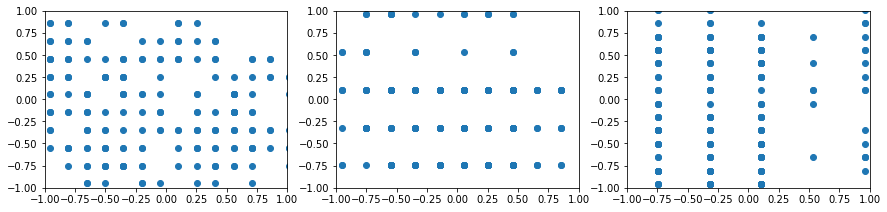

In [26]:
visualize_traces(np.random.permutation(norm_mat_ar_filt[:500,:]),norm_mat_ar_filt.shape[1])

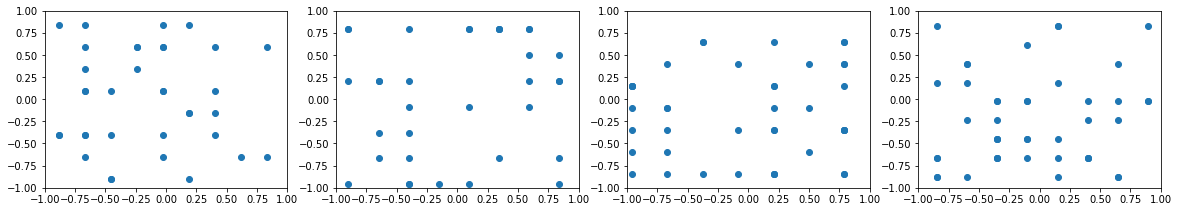

In [27]:
visualize_traces(np.random.permutation(norm_mat_si_filt[:100,:]), norm_mat_si_filt.shape[1])

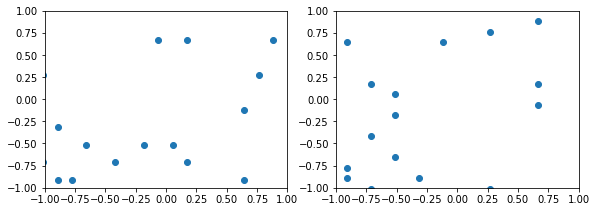

In [28]:
visualize_traces(np.random.permutation(norm_mat_vv_filt[:50,:]),norm_mat_vv_filt.shape[1])

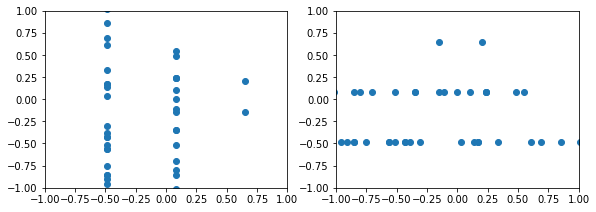

In [29]:
visualize_traces(np.random.permutation(norm_mat_sg_filt[:100,:]),norm_mat_sg_filt.shape[1])

### Visualize Clusters

In [30]:
'''
 Build the visualization of clusters.
 
'''
def f_plot(X,Xp,Y,ax):
    id3 = np.where(Y==3)
    id2 = np.where(Y==2)
    id1 = np.where(Y==1)
    id0 = np.where(Y==0)
    #plt.plot(X[id3],'bo')
    #plt.plot(X[id2],'ro')
    #plt.plot(X[id1],'go')
    #plt.plot(X[id0],'yo')
    ax.scatter(X[id3],Xp[id3],c='b')
    ax.scatter(X[id2],Xp[id2],c='r')
    ax.scatter(X[id1],Xp[id1],c='g')
    ax.scatter(X[id0],Xp[id0],c='y')


def visualize_Hint(norm_mat,Hint,n=11):
    nrows = 4
    fig = plt.figure(figsize=(20,15))
    for i in range(n):
        ax = plt.subplot(nrows, nrows, i+1)
        C_i = Hint[:,i]
        ax.set_xlim([0, 4])
        ax.set_ylim([0, 4])
        f_plot(norm_mat[:,i],norm_mat[:,i+1],C_i,ax)
    plt.show()

In [31]:
'''
 Build the visualization of clusters.
 
'''
def f_plot(X,Y):
    id3 = np.where(Y==3)
    id2 = np.where(Y==2)
    id1 = np.where(Y==1)
    id0 = np.where(Y==0)
    plt.plot(X[id3],'bo')
    plt.plot(X[id2],'ro')
    plt.plot(X[id1],'go')
    plt.plot(X[id0],'yo')


def visualize_Hint(norm_mat,Hint,n=11):
    nrows = 4
    fig = plt.figure(figsize=(20,15))
    for i in range(n):
        ax = plt.subplot(nrows, nrows, i+1)
        C_i = Hint[:,i]
        ax.set_xlim([0, 4])
        ax.set_ylim([0, 4])
        f_plot(norm_mat[:,i],C_i)
    plt.show()

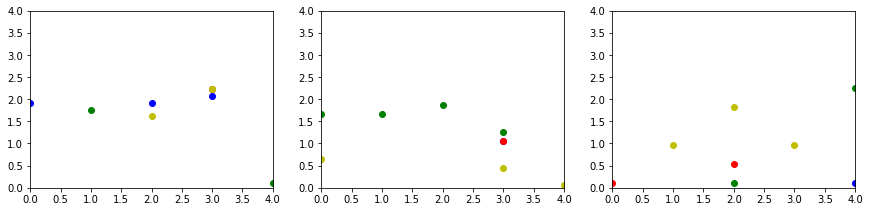

In [32]:
listp = np.random.permutation(range(norm_mat_ar_filt.shape[0]))
matrix_ar = norm_mat_ar_filt[listp,:]
matrix_hint_ar = Hint_ar[listp,:]
visualize_Hint(np.random.permutation(matrix_ar[:,:]),matrix_hint_ar[:,:],norm_mat_ar_filt.shape[1])

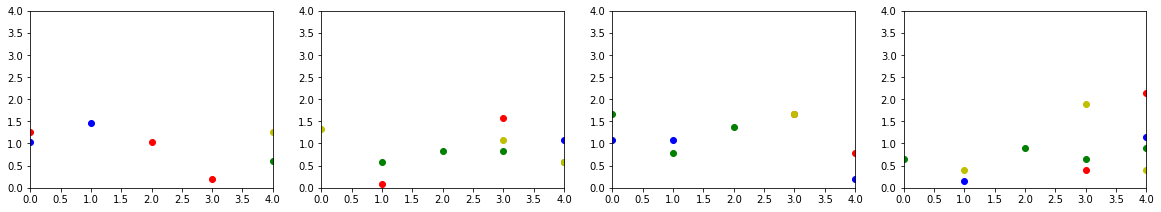

In [33]:
listp = np.random.permutation(range(norm_mat_si_filt.shape[0]))
matrix_si = norm_mat_si_filt[listp,:]
matrix_hint_si = Hint_si[listp,:]
visualize_Hint(np.random.permutation(matrix_si[:,:]),matrix_hint_si[:,:],norm_mat_si_filt.shape[1])

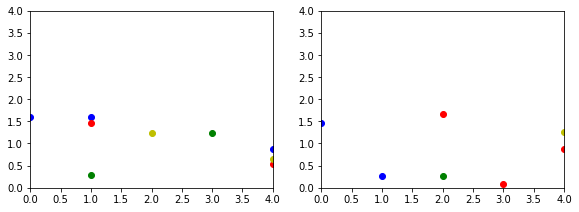

In [34]:
listp = np.random.permutation(range(norm_mat_vv_filt.shape[0]))
matrix_vv = norm_mat_vv_filt[listp,:]
matrix_hint_vv = Hint_vv[listp,:]
visualize_Hint(np.random.permutation(matrix_vv[:,:]),matrix_hint_vv[:,:],norm_mat_vv_filt.shape[1])

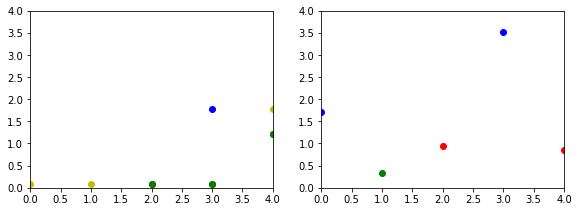

In [35]:
listp = np.random.permutation(range(norm_mat_sg_filt.shape[0]))
matrix_sg = norm_mat_sg_filt[listp,:]
matrix_hint_sg = Hint_sg[listp,:]
visualize_Hint(np.random.permutation(matrix_sg[:,:]),matrix_hint_sg[:,:],norm_mat_sg_filt.shape[1])

Estimation of Labels using Bernard,2017 [Learning Style Identifier: Improving the Precision of Learning Style Identification through Computational Intelligence Algorithms](https://doi.org/10.1016/j.eswa.2017.01.021). and Graf,2009 [Supporting teachers in identifying students’ learning styles in learning management systems:  An automatic student modeling approach](https://www.jstor.org/stable/jeductechsoci.12.4.3?seq=1#metadata_info_tab_contents)


In [36]:
from IPython.display import display, Math, Latex

In [37]:
#display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))
display(Math(r'LS_{i} = \frac{\sum_{i=1}^{n} C_{ij}}{N}'))

<IPython.core.display.Math object>

### 6. Built Labels

In [38]:
Y_ar = ((Hint_ar.sum(axis=1)/Hint_ar.shape[1]))
Y_si = ((Hint_si.sum(axis=1)/Hint_si.shape[1]))
Y_vv = ((Hint_vv.sum(axis=1)/Hint_vv.shape[1]))
Y_sg = ((Hint_sg.sum(axis=1)/Hint_sg.shape[1]))
Y_norm_ar = ((Hint_ar.sum(axis=1)/Hint_ar.shape[1]))/2
Y_norm_si = ((Hint_si.sum(axis=1)/Hint_si.shape[1])-1)/2
Y_norm_vv = ((Hint_vv.sum(axis=1)/Hint_vv.shape[1])-1)/2
Y_norm_sg = ((Hint_sg.sum(axis=1)/Hint_sg.shape[1])-1)/2
Hint_ar[0]

array([1., 1., 3.])

16.333333333333336
12.75
18.5
13.5
1.4017094017094018
0.6395995532946908


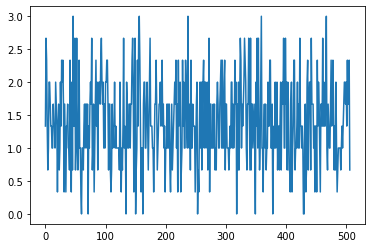

In [39]:
print(Y_ar[:10].sum())
print(Y_si[:10].sum())
print(Y_vv[:10].sum())
print(Y_sg[:10].sum())
print (Y_ar.mean())
print (Y_ar.std())
plt.plot(np.random.permutation(Y_ar))


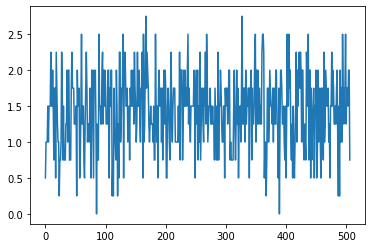

In [40]:
plt.plot(Y_si)


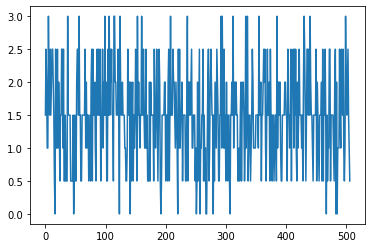

In [41]:
plt.plot(Y_vv)


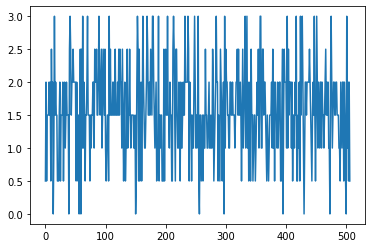

In [42]:
plt.plot(Y_sg)
plt.show()

### Visualize distribution of learning style, under the hypothesis that student behavioral is independent in the learning platform (i.i.d)


In [43]:
'''
 Build the visualization of clusters.
 
'''
def learning_style_distribution(y_ls, ls="LS"):
    mini  = y_ls.min()
    maxi  = y_ls.max()
    mu    = y_ls.mean()
    sigma = y_ls.std()
    # calculate the z-transform
    z1 = ( mini - mu ) / sigma
    z2 = ( maxi - mu ) / sigma

    x = np.arange(z1, z2, 0.01) # range of x in spec
    # mean = 0, stddev = 1, since Z-transform was calculated
    y = norm.pdf(x,0,1)
    y2 = norm.pdf(y_ls,0,1)

    fig, ax = plt.subplots(figsize=(9,6))
    plt.style.use('fivethirtyeight')
    ax.plot(y_ls,y2)
    ax.fill_between(x,y,0, alpha=0.3, color='b')
    ax.fill_between(y_ls,y2,0, alpha=0.1)
    ax.set_xlim([-maxi,maxi])
    ax.set_xlabel('# of Standard Deviations Outside the Mean')
    ax.set_yticklabels([])
    ax.set_title('Normal Gaussian Curve '+ls)
    #plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
    plt.show()



In [44]:
#yar = np.asarray(sorted(Y_ar))
#learning_style_distribution(yar,"FSLSM A\R")

In [45]:
#ysi = np.asarray(sorted(Y_si))
#learning_style_distribution(ysi,"FSLSM S\I")

In [46]:
#yvv = np.asarray(sorted(Y_vv))
#learning_style_distribution(yvv,"FSLSM V\V")

In [47]:
#ysg = np.asarray(sorted(Y_sg))
#learning_style_distribution(ysg,"FSLSM S\G")

### Affect each student to its prior relevant classes.
According to Baldiris S., & Graf. S, 2011 [Dynamic User Modeling and Adaptation Based on Learning Styles for Supporting Semi-Automatic Generation of IMS Learning Design](https://doi.org/10.1109/ICALT.2011.70)
 


   ***FSLSM scaling preferences*** <br>
    <img src="./images/FSLSM_AR_dimension.png" width="55%" heigth="55%"><br>



   ***Dynamic scaling FSLSM using graf***<br>
    <img src="./images/FSLSM_std.png" width="55%" heigth="55%" >

In [48]:
def plot_distribution_data(Y_ar,ls="Active\Reflective"):
    h = sorted(Y_ar)  #sorted
    mu = np.mean(h)
    sigma = np.std(h)
    mini = h[0]
    maxi = h[len(h)-1]
    print('m = {}'.format(mu), 'sigma ={}'.format(sigma))
    fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
    idxmu_m_sigma = np.where(h<mu-sigma)[0]
    idxmu_p_sigma = np.where(h>mu+sigma)[0]
    #x = np.linspace(mini,(mu-sigma),len(idxmu_m_sigma))
    print(len(idxmu_m_sigma))
    print(len(idxmu_p_sigma))
    width = len(h)-(len(idxmu_m_sigma)+len(idxmu_p_sigma))
    print ("Balanced students number = ",width)
    #fit_x = fit[idxmu_m_sigma]
    #pl.fill_between(x,fit_x,0, alpha=0.3, color='b')
    #pl.figure(figsize=(30,15))
    pl.plot(h,fit,'-o')
    #----------------------------------------------------------------------------------------#
    # fill area 1

    pt1 = mu + sigma
    plt.plot([pt1 ,pt1 ],[0.0,norm.pdf(pt1 ,mu, sigma)], color='black')

    pt2 = mu - sigma
    plt.plot([pt2 ,pt2 ],[0.0,norm.pdf(pt2 ,mu, sigma)], color='black')

    ptx = np.linspace(pt1, pt2,width)
    pty = norm.pdf(ptx,mu,sigma)

    #plt.fill_between(ptx, pty, color='#0b559f', alpha='1.0')
    plt.fill_between(ptx, pty, color='red', alpha='1.0')
    #----------------------------------------------------------------------------------------#
    # fill area 2

    pt1 = mu + sigma
    plt.plot([pt1 ,pt1 ],[0.0,norm.pdf(pt1 ,mu, sigma)], color='black')

    pt2 = maxi#mu + 10.0 *sigma
    plt.plot([pt2 ,pt2 ],[0.0,norm.pdf(pt2 ,mu, sigma)], color='black')

    ptx = np.linspace(pt1, pt2,len(idxmu_p_sigma))
    pty = norm.pdf(ptx,mu,sigma)

    plt.fill_between(ptx, pty, color='yellow', alpha='1.0')

    #----------------------------------------------------------------------------------------#
    # fill area 3

    pt1 = mu  - sigma
    plt.plot([pt1 ,pt1 ],[0.0,norm.pdf(pt1 ,mu, sigma)], color='black')

    pt2 = mini  #mu - 10.0 *sigma
    plt.plot([pt2 ,pt2 ],[0.0,norm.pdf(pt2 ,mu, sigma)], color='black')

    ptx = np.linspace(pt1, pt2,len(idxmu_m_sigma))
    pty = norm.pdf(ptx,mu,sigma)

    plt.fill_between(ptx, pty, color='green', alpha='1.')

    plt.grid()
    #pl.grid()
    plt.title('Distribution FSLSM {}'.format(ls),fontsize=10)
    pl.xlabel('LS magnitude',fontsize=10)
    pl.ylabel('Distribution',fontsize=10)

    #pl.hist(h,normed=True)      #use this to draw histogram of your data
    
    pl.show()

def extract_prior_label(X, y):
    N = len(y)
    #y = np.sort(y)
    mu = y.mean()
    sigma = y.std()
    z1 = mu - sigma
    z2 = mu + sigma
    ind_strong = np.where(y>z2)[0] # 1 strong preference
    nb_ind_act = len(ind_strong)
    ind_less = np.where(y<z1)[0] # -1 low  preference
    nb_ind_ref = len(ind_less)

    X_str = X[ind_strong,:]
    print(np.shape(X_str))
    print(np.shape(X[ind_less,:]))
    X_final = np.concatenate((X_str,X[ind_less,:]),axis=0)
    y_strong = y[ind_strong]
    y_final = np.concatenate((y_strong,y[ind_less]),axis=0)
    y_label = np.concatenate((np.ones((nb_ind_act,1)),np.zeros((nb_ind_ref,1))),axis=0)

    print ("Number of E {} so {:02.2f}%".format(nb_ind_act,nb_ind_act*100/N))
    print ("Number of none E {} so {:02.2f}%".format(nb_ind_ref,nb_ind_ref*100/N))
    print ("Number of student with balanced behaviour {} so {:02.2f}%".format(N-(nb_ind_act+nb_ind_ref),(1-(nb_ind_act+nb_ind_ref)/N)*100))
    return X_final, y_final,y_label, ind_strong,ind_less



m = 0.7008547008547009 sigma =0.3197997766473454
88
63
Balanced students number =  356


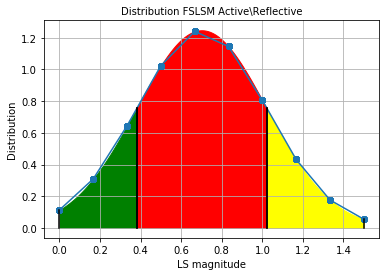

(63, 3)
(88, 3)
Number of E 63 so 12.43%
Number of none E 88 so 17.36%
Number of student with balanced behaviour 356 so 70.22%


In [49]:
plot_distribution_data(Y_ar/2)
unbalance_Hint_ar,unbalance_y_ar,unbalance_label_ar, id_active_student, id_reflective_student= extract_prior_label(Hint_ar,Y_ar)

m = 0.7174556213017751 sigma =0.2657532473262673
84
112
Balanced students number =  311


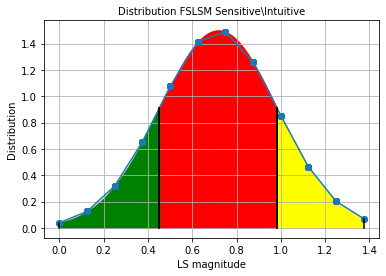

(112, 4)
(84, 4)
Number of E 112 so 22.09%
Number of none E 84 so 16.57%
Number of student with balanced behaviour 311 so 61.34%


In [50]:
plot_distribution_data(Y_si/2,"Sensitive\Intuitive")
unbalance_Hint_si,unbalance_y_si,unbalance_label_si, id_sensitive_student, id_intuitive_student= extract_prior_label(Hint_si,Y_si)

m = 0.7421104536489151 sigma =0.36479288607774446
101
87
Balanced students number =  319


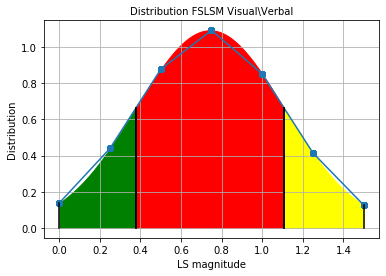

(87, 2)
(101, 2)
Number of E 87 so 17.16%
Number of none E 101 so 19.92%
Number of student with balanced behaviour 319 so 62.92%


In [51]:
plot_distribution_data(Y_vv/2,"Visual\Verbal")
unbalance_Hint_vv,unbalance_y_vv,unbalance_label_vv,id_visual_student, id_verbal_student= extract_prior_label(Hint_vv,Y_vv)

m = 0.7864891518737672 sigma =0.3516653832772471
71
79
Balanced students number =  357


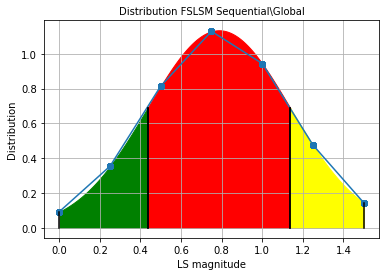

(79, 2)
(71, 2)
Number of E 79 so 15.58%
Number of none E 71 so 14.00%
Number of student with balanced behaviour 357 so 70.41%


In [52]:
plot_distribution_data(Y_sg/2,"Sequential\Global")
unbalance_Hint_sg,unbalance_y_sg,unbalance_label_sg,id_sequential_student, id_global_student = extract_prior_label(Hint_sg,Y_sg)

### 8. Remove balanced student learning behaviour

(151, 3)
(196, 4)
(188, 2)
(150, 2)
FSLSM AR label [[0. 0. 0. 0.]]
FSLSM AR value [0.66666667 0.66666667 0.33333333 0.33333333]


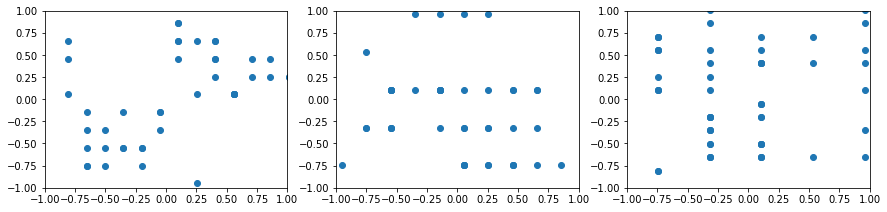

FSLSM SI label [[0. 0. 0. 0.]]
FSLSM SI value [0.75 0.5  0.25 0.25]


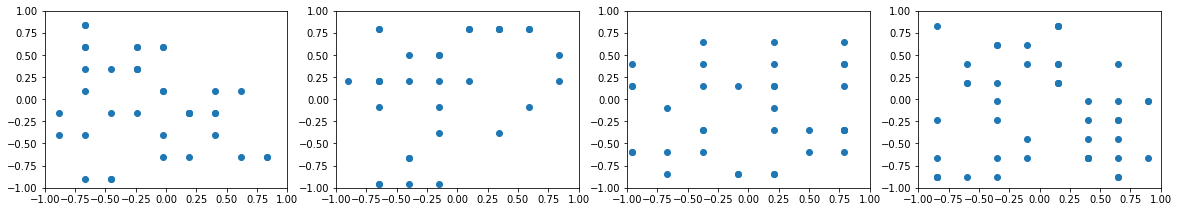

FSLSM VV label [[0. 0. 0. 0.]]
FSLSM VV value [0.5 0.  0.  0.5]


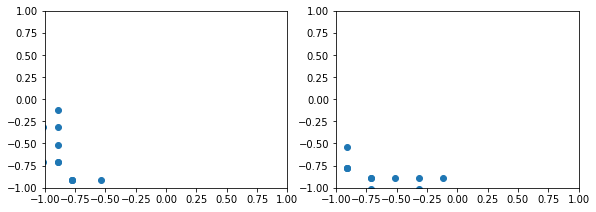

FSLSM SG label [[1. 1. 1. 1. 1.]]
FSLSM SG value [2.5 3.  2.5 3.  2.5]


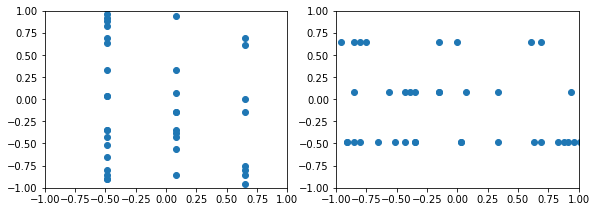

In [53]:
list_ar = sorted(list(id_active_student)+list(id_reflective_student)) #id_active_student, id_reflective_student
list_si = sorted(list(id_sensitive_student)+list(id_intuitive_student))#id_sensitive_student, id_intuitive_student
list_vv = sorted(list(id_visual_student)+list(id_verbal_student))#id_visual_student, id_verbal_student
list_sg = sorted(list(id_sequential_student)+list(id_global_student))#id_sequential_student, id_global_student

print (unbalance_Hint_ar.shape)
print (unbalance_Hint_si.shape)
print (unbalance_Hint_vv.shape)
print (unbalance_Hint_sg.shape)
#unbalance_Hint_ar
print ("FSLSM AR label",unbalance_label_ar[-5:-1].T)
print ("FSLSM AR value",unbalance_y_ar[-5:-1])
visualize_traces(np.random.permutation(norm_mat_ar_filt[list_ar[:100],:]),norm_mat_ar_filt.shape[1])

print ("FSLSM SI label",unbalance_label_si[-5:-1].T)
print ("FSLSM SI value",unbalance_y_si[-5:-1])
visualize_traces(np.random.permutation(norm_mat_si_filt[list_si[:100],:]),norm_mat_si_filt.shape[1])

print ("FSLSM VV label",unbalance_label_vv[-5:-1].T)
print ("FSLSM VV value",unbalance_y_vv[-5:-1])
visualize_traces(np.random.permutation(norm_mat_vv_filt[list_vv[:100],:]),norm_mat_vv_filt.shape[1])

print ("FSLSM SG label",unbalance_label_sg[0:5].T)
print ("FSLSM SG value",unbalance_y_sg[0:5])
visualize_traces(np.random.permutation(norm_mat_sg_filt[list_ar[:100],:]),norm_mat_sg_filt.shape[1])

## Save matrices 
1. Data Feature selection
2. Normalize student traces
3. Hint (Cluster column wise student preferences)
4. Relevant Indexes student strong preferences
5. Normalize student traces with strong preferences
6. Hint of student traces with strong preferences
7. Label of Student Preferences

## Part2. Deep neural net Modeling

In [54]:

targets = {}
for i in range(0, len(data)):
    targets[i] = data[i][1]

FSLSM = ["AR","SI","VV","SG"]

In [55]:
for i in range(0, len(data)):
    nb1 = (targets[i]==1).sum()
    nb2 = (targets[i]==0).sum()
    print ("Felder's Dimension: ",LS[i],"\t",Classes [i][0], ": ",nb1, "\n\t\t\t\t\t",Classes [i][1], ": ",nb2)

Felder's Dimension:  Processing 	 Active :  244 
					 Reflective :  263
Felder's Dimension:  Perception 	 Sensitive :  348 
					 Intuitive :  159
Felder's Dimension:  Input 	 Visual :  388 
					 Verbal :  119
Felder's Dimension:  Understanding 	 Sequential :  250 
					 Global :  257


In [56]:
def evaluation_surclassifieur_naif(pos):
    X_train, X_test, Y_train, Y_test  = train_test_split(data[pos][0],targets[pos], test_size=0.2,random_state=0)
    # DummyClassifier to predict only target 0
    print("Classifieur Naif pour: ",LS[pos])
    dummy = DummyClassifier(strategy='most_frequent').fit(X_train, Y_train)
    dummy_pred = dummy.predict(X_test)

    # checking unique labels
    print('Style d\'apprentissage majoritaire prédit: ', Classes[pos][int(np.unique(dummy_pred))])

    # checking accuracy
    print('Test score: ', metrics.accuracy_score(Y_test, dummy_pred))

In [57]:
evaluation_surclassifieur_naif(0)

Classifieur Naif pour:  Processing
Style d'apprentissage majoritaire prédit:  Active
Test score:  0.5490196078431373


In [58]:
evaluation_surclassifieur_naif(1)

Classifieur Naif pour:  Perception
Style d'apprentissage majoritaire prédit:  Intuitive
Test score:  0.7941176470588235


In [59]:
evaluation_surclassifieur_naif(2)

Classifieur Naif pour:  Input
Style d'apprentissage majoritaire prédit:  Verbal
Test score:  0.7254901960784313


In [60]:
evaluation_surclassifieur_naif(3)

Classifieur Naif pour:  Understanding
Style d'apprentissage majoritaire prédit:  Sequential
Test score:  0.49019607843137253


### Analysis of Philippines

In [61]:
 #Data
 np.save("./output/data/phili2017/pareto_ar.npy",mat_ar)
 np.save("./output/data/phili2017/pareto_si.npy",mat_si)
 np.save("./output/data/phili2017/pareto_vv.npy",mat_vv)
 np.save("./output/data/phili2017/pareto_sg.npy",mat_sg)
 #Normalize
 np.save("./output/data/phili2017/norm_ar.npy",norm_mat_ar_filt)
 np.save("./output/data/phili2017/norm_si.npy",norm_mat_si_filt)
 np.save("./output/data/phili2017/norm_vv.npy",norm_mat_vv_filt)
 np.save("./output/data/phili2017/norm_sg.npy",norm_mat_sg_filt)
 #Hint
 np.save("./output/data/phili2017/Hint_ar.npy",Hint_ar)
 np.save("./output/data/phili2017/Hint_si.npy",Hint_si)
 np.save("./output/data/phili2017/Hint_vv.npy",Hint_vv)
 np.save("./output/data/phili2017/Hint_sg.npy",Hint_sg)
 #Relevant Students Indexphili2017/ list with strong preferences
 np.save("./output/data/phili2017/index_strong_ar.npy",list_ar)
 np.save("./output/data/phili2017/index_strong_si.npy",list_si)
 np.save("./output/data/phili2017/index_strong_vv.npy",list_vv)
 np.save("./output/data/phili2017/index_strong_sg.npy",list_sg)
 #Normalize traces of students with strong preferences
 np.save("./output/data/phili2017/norm_strong_ar.npy",norm_mat_ar_filt[list_ar,:])
 np.save("./output/data/phili2017/norm_strong_si.npy",norm_mat_si_filt[list_si,:])
 np.save("./output/data/phili2017/norm_strong_vv.npy",norm_mat_vv_filt[list_vv,:])
 np.save("./output/data/phili2017/norm_strong_sg.npy",norm_mat_sg_filt[list_sg,:])
 # Hint of student traces with strong preferences
 np.save("./output/data/phili2017/strong_hint_ar.npy",unbalance_Hint_ar)
 np.save("./output/data/phili2017/strong_hint_si.npy",unbalance_Hint_si)
 np.save("./output/data/phili2017/strong_hint_vv.npy",unbalance_Hint_vv)
 np.save("./output/data/phili2017/strong_hint_sg.npy",unbalance_Hint_sg)
 # Labelled student preference FSLSM
 np.save("./output/data/phili2017/unbalanced_label_ar.npy",unbalance_label_ar)
 np.save("./output/data/phili2017/unbalanced_label_si.npy",unbalance_label_si)
 np.save("./output/data/phili2017/unbalanced_label_vv.npy",unbalance_label_vv)
 np.save("./output/data/phili2017/unbalanced_label_sg.npy",unbalance_label_sg)

### 9. Isomorphic tansformation of Hint for the model

In [62]:
#binarized data
""" transform features in binary format to train in the DBN.
@Input: Hint: matrix of preferences
@Output: xp : binarized data to be trained by te model
"""
def binarized_features(data):
    enc = {}
    (m,n) = data.shape
    nb_features = 3*n
    enc[0] = [0, 0, 1]
    enc[1] = [0, 1, 0]
    enc[2] = [0, 1, 1]
    enc[3] = [1, 0, 0]
    xp = np.zeros((data.shape[0],nb_features))
    for i,row in enumerate(data):
        l = [enc[elt] for elt in row]
        xp[i] = np.hstack(l)
    return xp

In [63]:
bin_Hint_ar =binarized_features(unbalance_Hint_ar)
bin_Hint_ar[0]

array([1., 0., 0., 0., 1., 0., 1., 0., 0.])

In [64]:
#bin_Hint_si =binarized_features(unbalance_Hint_si)
#bin_Hint_si[0]

In [65]:
#bin_Hint_vv =binarized_features(unbalance_Hint_vv)
#bin_Hint_vv[0]

In [66]:
bin_Hint_sg =binarized_features(unbalance_Hint_sg)
bin_Hint_sg[0]

array([0., 1., 1., 1., 0., 0.])

### 10. Instantiate the model

In [99]:
from model.MDBN import MDBN   #model.MDBN import MDBN

In [101]:
dbn_feats_ar = np.load("./output/data/phili2017/Hint_ar.npy")
label_ar = data[0][1]
np.save("./output/data/phili2017/labels/label_ar.npy",label_ar)
dbn_feats_si = np.load("./output/data/phili2017/Hint_si.npy")
label_si = data[1][1]
np.save("./output/data/phili2017/labels/label_si.npy",label_si)
dbn_feats_vv = np.load("./output/data/phili2017/Hint_vv.npy")
label_vv = data[2][1]
np.save("./output/data/phili2017/labels/label_vv.npy",label_vv)
dbn_feats_sg = np.load("./output/data/phili2017/Hint_sg.npy")
label_sg = data[3][1]
np.save("./output/data/phili2017/labels/label_sg.npy",label_sg)
binarized_features(dbn_feats_ar)

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

### Procesing Dimension

In [69]:
#Spliting the data
X_hint_bint = binarized_features(dbn_feats_ar)
X_dbn, X_test, Y_dbn, Y_test  = train_test_split(X_hint_bint,label_ar, test_size=0.2,random_state=1234)
cw = {}
for l in set(Y_dbn):
    cw[l] = np.sum(Y_dbn == l)  
cw

{0: 210, 1: 195}

In [102]:

def evaluation_model_MLSIM(X_dbn,Y_dbn,batch_size=35, learning_rate=0.6730678657443401,epochs=965, C=0.7927241,fslsm_dim="A/R"):
       
    print("Model MLSIM pour: ",fslsm_dim)
    n = np.shape(X_dbn)[0]
    m = np.shape(X_dbn)[1]
    print ("Nbr students:", n)
    print ("Learning traces dimension:",m)
    # construct DBN
    nhid_param1 = 15#int(1.5*m)  #HYPERPARAMS.nb_hiden_node2 #nobre de noeuds de la deuxime couche cachée
    nhid_param2 = 10#m    #int(m/2) #HYPERPARAMS.nb_hiden_node1 #nobre de noeuds de la premiere couche cachée
    #dbn = MDBN(input_data=X_train_feats, label=Y_train, input_size=m, hidden_layer_sizes=[nhid_param1, nhid_param2], output_size=1, batch_size=Training.batch_size, learning_rate=HYPERPARAMS.learning_rate,epochs=Training.epochs, C=HYPERPARAMS.C)
    dbn = MDBN(input_data=X_dbn, label=Y_dbn, input_size=m, hidden_layer_sizes=[nhid_param1, nhid_param2], batch_size=batch_size, learning_rate=learning_rate,epochs=epochs, C=C)    
    start = time.time()
    # pre-training (TrainUnsupervisedDBN)
    print ("Training the Hybrid Deep Belief Net model \n................")
    dbn.train(X_dbn,verbose=True)
    print ("Unsupervised training time: ",(time.time()-start)," seconds")
    # fine-tuning (DBNSupervisedFineTuning)
    #synthetic_V_list, h_list = dbn.predict(X_dbn)
    return dbn

In [111]:
def plot_auc(y,yhat):
    plt.plot([0, 1], [1, 0], linestyle='--', label='No Skill')

    # calculate inputs for the PR curve
    precision, recall, thresholds = precision_recall_curve(y, yhat)

    # plot PR curve
    plt.plot(recall, precision, marker='.', label='DBN-LIS')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.show()

    # calculate and print PR AUC
    auc_pr = auc(recall, precision)

    print('AUC PR: %.3f' % auc_pr)

In [112]:
dbn = evaluation_model_MLSIM(X_dbn,Y_dbn,fslsm_dim="A/R")

1 Reconstruction error 0.661338 	Weigths 21.594300 hbias 2.736698 vbias 3.444904  
>> Epoch 113 finished 	RBM 1 Reconstruction error 0.642720 	Weigths 21.672703 hbias 2.727949 vbias 3.487192  
>> Epoch 114 finished 	RBM 1 Reconstruction error 0.666276 	Weigths 21.781500 hbias 2.688331 vbias 3.453378  
>> Epoch 115 finished 	RBM 1 Reconstruction error 0.619904 	Weigths 21.877921 hbias 2.671694 vbias 3.455022  
>> Epoch 116 finished 	RBM 1 Reconstruction error 0.636108 	Weigths 21.992395 hbias 2.677405 vbias 3.359400  
>> Epoch 117 finished 	RBM 1 Reconstruction error 0.610390 	Weigths 22.050157 hbias 2.679512 vbias 3.476510  
>> Epoch 118 finished 	RBM 1 Reconstruction error 0.609659 	Weigths 22.150057 hbias 2.709079 vbias 3.404446  
>> Epoch 119 finished 	RBM 1 Reconstruction error 0.602791 	Weigths 22.225586 hbias 2.726907 vbias 3.526355  
>> Epoch 120 finished 	RBM 1 Reconstruction error 0.574191 	Weigths 22.289766 hbias 2.722676 vbias 3.485651  
>> Epoch 121 finished 	RBM 1 Reconstr

In [105]:
w = dbn.getweights()

In [106]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,precision_recall_curve,auc

In [109]:
msg = "Train data"
predictions = dbn.finetune(X_dbn,Y_dbn,msg,rng,bytraining=True)
print (msg," Model accuracy :",accuracy_score(Y_dbn,predictions))
print (msg," Confusion matrix :\n",confusion_matrix(Y_dbn,predictions))

Training with SVM
Finetuning with SVM
[LibSVM]Time fitting the data:  0.018208980560302734
Train data  Model accuracy : 0.8716049382716049
Train data  Confusion matrix :
 [[189  21]
 [ 31 164]]


Test data  Model accuracy : 0.8529411764705882
Test data  Confusion matrix :
 [[49  4]
 [11 38]]


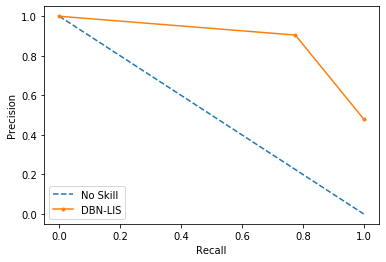

AUC PR: 0.894


In [110]:
msg = "Test data"
predictions = dbn.finetune(X_test,Y_test,msg,rng,bytraining=False)
print (msg," Model accuracy :",accuracy_score(Y_test,predictions))
print (msg," Confusion matrix :\n",confusion_matrix(Y_test,predictions))
plot_auc(Y_test,predictions)

### Perception Dimension

In [85]:
#Spliting the data
X_hint_bint_si = binarized_features(dbn_feats_si)
X_dbn_si, X_test_si, Y_dbn_si, Y_test_si  = train_test_split(X_hint_bint_si,label_si, test_size=0.2,random_state=1234) 
for l in set(Y_dbn_si):
    cw[l] = np.sum(Y_dbn_si == l)  
cw

{0: 130, 1: 275}

In [86]:
dbn_si = evaluation_model_MLSIM(X_dbn_si,Y_dbn_si,fslsm_dim="S/I")

Model MLSIM pour:  S/I
Nbr students: 405
Learning traces dimension: 12
Initialize weigths [[-0.01596887 -0.00261666 -0.08281655 -0.07960763  0.06345034 -0.01215365
   0.0567143  -0.08154517 -0.04069298 -0.01624902  0.0398383  -0.06815829]
 [-0.03086468  0.0087279   0.03736435  0.03576828 -0.07269085  0.06185526
  -0.01835787  0.06073128 -0.0671721   0.05299723 -0.08167518  0.05597351]
 [-0.02810016  0.06882404 -0.0208327   0.07134191  0.0721025   0.05339886
   0.01137466  0.04004959  0.06962324 -0.04399762  0.03915128  0.0439105 ]
 [ 0.00878373 -0.04819264 -0.00902965 -0.01261191 -0.00629013  0.05833596
   0.02852529  0.02635185  0.02653269 -0.02579599 -0.06354579  0.07132422]
 [-0.03636844 -0.07729061 -0.04046897 -0.07187929  0.07440346 -0.06141555
  -0.06175646 -0.04128731 -0.01053865  0.02683099  0.05246527  0.04513667]
 [-0.02426157  0.05234086  0.05367686  0.06922957  0.04561658  0.02602381
   0.04757565  0.0165821  -0.06576491 -0.04841803 -0.00057559 -0.06946868]
 [ 0.06410197 -0

In [90]:
msg_si = "Train data"
#predictions = dbn_si.finetune(X_dbn_si,Y_dbn_si,msg_si,rng,weight=True,bytraining=True)
predictions = dbn_si.finetune(X_dbn_si,Y_dbn_si,msg_si,rng,bytraining=True)
print (msg_si," Model accuracy :",accuracy_score(Y_dbn_si,predictions))
print (msg_si," Confusion matrix :\n",confusion_matrix(Y_dbn_si,predictions))

Training with SVM
Finetuning with SVM
[LibSVM]Time fitting the data:  0.0308380126953125
Train data  Model accuracy : 0.8049382716049382
Train data  Confusion matrix :
 [[ 63  67]
 [ 12 263]]


Test data  Model accuracy : 0.7549019607843137
Test data  Confusion matrix :
 [[ 9 20]
 [ 5 68]]


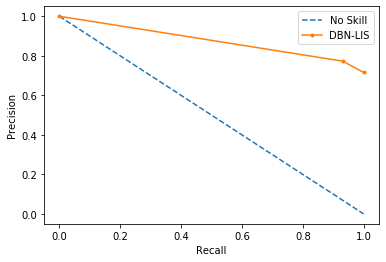

AUC PR: 0.877


In [91]:
msg_si = "Test data"
predictions = dbn_si.finetune(X_test_si,Y_test_si,msg_si,rng,bytraining=False)
print (msg_si," Model accuracy :",accuracy_score(Y_test_si,predictions))
print (msg_si," Confusion matrix :\n",confusion_matrix(Y_test_si,predictions))
plot_auc(Y_test_si,predictions)

### Input Dimension

In [92]:
#Spliting the data
X_hint_bint_vv = binarized_features(dbn_feats_vv)
X_dbn_vv, X_test_vv, Y_dbn_vv, Y_test_vv  = train_test_split(X_hint_bint_vv,label_vv, test_size=0.2,random_state=1234) 
for l in set(Y_dbn_vv):
    cw[l] = np.sum(Y_dbn_vv == l)  
cw

{0: 98, 1: 307}

In [93]:
dbn_vv = evaluation_model_MLSIM(X_dbn_vv,Y_dbn_vv,fslsm_dim="V/V")

Model MLSIM pour:  V/V
Nbr students: 405
Learning traces dimension: 6
Initialize weigths [[-0.06289319 -0.08796182  0.09020296  0.06712803 -0.02754918 -0.13748082]
 [ 0.02547514 -0.12974749  0.07846137 -0.16012505 -0.07030904 -0.10960022]
 [-0.07195587  0.08383052 -0.16063957 -0.16330525  0.09845627  0.14056692]
 [-0.02655491  0.12322496 -0.10543643  0.0871248  -0.0619651  -0.12265001]
 [-0.06338865 -0.04262949 -0.14682134 -0.065881   -0.04111463  0.15214888]
 [ 0.01127848  0.14893484 -0.0922184   0.04770095 -0.08518541  0.03000014]
 [ 0.00835439 -0.0337376   0.077217   -0.14530746 -0.07254228 -0.10987955]
 [-0.02550045 -0.08750644 -0.00665904  0.14082992  0.14350358 -0.12634078]
 [-0.04174515 -0.1428938  -0.09968428  0.00522984 -0.14447709 -0.04772706]]
Initialize weigths [[-0.0645678   0.09722928  0.10593466  0.00067677 -0.10864154  0.00144847
  -0.08523875  0.06857542 -0.10827886]
 [-0.03832462  0.02750786  0.02153846 -0.05404023  0.03065001  0.00339209
  -0.00504888 -0.03554119  0.

In [94]:
msg_vv = "Train data"
predictions = dbn_vv.finetune(X_dbn_vv,Y_dbn_vv,msg_vv,rng,bytraining=True)
print (msg_si," Model accuracy :",accuracy_score(Y_dbn_vv,predictions))
print (msg_si," Confusion matrix :\n",confusion_matrix(Y_dbn_vv,predictions))

Training with SVM
Finetuning with SVM
[LibSVM]Time fitting the data:  0.013859033584594727
Test data  Model accuracy : 0.8320987654320988
Test data  Confusion matrix :
 [[ 87  11]
 [ 57 250]]


Test data  Model accuracy : 0.8333333333333334
Test data  Confusion matrix :
 [[19  2]
 [15 66]]


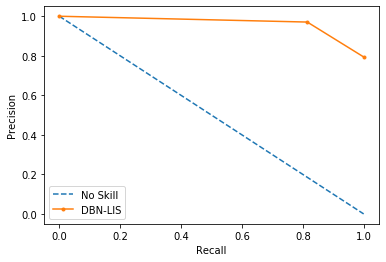

AUC PR: 0.966


In [95]:
msg_vv = "Test data"
predictions = dbn_vv.finetune(X_test_vv,Y_test_vv,msg_si,rng,bytraining=False)
print (msg_si," Model accuracy :",accuracy_score(Y_test_vv,predictions))
print (msg_si," Confusion matrix :\n",confusion_matrix(Y_test_vv,predictions))
plot_auc(Y_test_vv,predictions)

### Sequential Global

In [105]:
#Spliting the data
X_hint_bint_sg = binarized_features(dbn_feats_sg)
X_dbn_sg, X_test_sg, Y_dbn_sg, Y_test_sg  = train_test_split(X_hint_bint_sg,label_sg, test_size=0.2,random_state=1234) 
for l in set(Y_dbn_sg):
    cw[l] = np.sum(Y_dbn_sg == l)  
cw

{0: 205, 1: 200}

In [97]:
dbn_sg = evaluation_model_MLSIM(X_dbn_sg,Y_dbn_sg,fslsm_dim="S/G")

Model MLSIM pour:  S/G
Nbr students: 405
Learning traces dimension: 6
Initialize weigths [[-0.10649857  0.15944421  0.14237108  0.10550546  0.15535782  0.06568357]
 [ 0.12262439 -0.07056288  0.09479935 -0.11039681  0.01842102  0.0858132 ]
 [ 0.03061028  0.08865931  0.0724998   0.15006079  0.03661129 -0.12733215]
 [-0.12236434  0.13132504 -0.16236275  0.09276987 -0.05594334  0.03205186]
 [ 0.03646639 -0.01571868  0.09832193  0.10810701  0.04551361  0.08423185]
 [-0.01707017  0.13256496 -0.10951471  0.02548398 -0.06512597  0.14864974]
 [-0.14896345 -0.08684169  0.05520615  0.0313474   0.12420293  0.12831383]
 [-0.1364601  -0.08808895  0.07476718  0.02488932  0.12693459 -0.10200512]
 [-0.13583163 -0.1390755  -0.02897247  0.12815857 -0.15726062  0.13436596]]
Initialize weigths [[ 0.04617609  0.02263288  0.00023698  0.00158687 -0.05524604 -0.07691858
   0.08668696 -0.07091208  0.09036701]
 [-0.07543993 -0.07686599 -0.09033309 -0.0612902   0.04387103 -0.06711055
   0.04780585  0.0633652  -0.

In [101]:
msg_sg = "Train data"
predictions = dbn_sg.finetune(X_dbn_sg,Y_dbn_sg,msg_sg,rng,bytraining=True)
print (msg_si," Model accuracy :",accuracy_score(Y_dbn_sg,predictions))
print (msg_si," Confusion matrix :\n",confusion_matrix(Y_dbn_sg,predictions))

Training with SVM
Finetuning with SVM
[LibSVM]Time fitting the data:  0.021225929260253906
Test data  Model accuracy : 0.674074074074074
Test data  Confusion matrix :
 [[187  18]
 [114  86]]


Test data  Model accuracy : 0.6176470588235294
Test data  Confusion matrix :
 [[49  3]
 [36 14]]


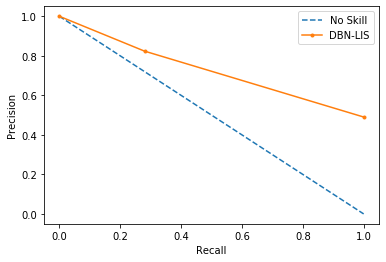

AUC PR: 0.728


In [104]:
msg = "Test data"
predictions = dbn_sg.finetune(X_test_sg,Y_test_sg,msg,rng,bytraining=False)
print (msg," Model accuracy :",accuracy_score(Y_test_sg,predictions))
print (msg," Confusion matrix :\n",confusion_matrix(Y_test_sg,predictions))
plot_auc(Y_test_sg,predictions)